In [10]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

!pip install wordcloud==1.8.0

from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

stopwords = set(stopwords.words('english'))
sns.set_theme()

     |████████████████████████████████| 217 kB 6.9 MB/s eta 0:00:01
  ERROR: Command errored out with exit status 1:
   command: /Users/vikram/opt/anaconda3/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/8v/9q30g5pj18g_92_3ns_tnqk00000gn/T/pip-install-0tkwhnfk/wordcloud_a0220ff14d194763ace118321fe36c88/setup.py'"'"'; __file__='"'"'/private/var/folders/8v/9q30g5pj18g_92_3ns_tnqk00000gn/T/pip-install-0tkwhnfk/wordcloud_a0220ff14d194763ace118321fe36c88/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/8v/9q30g5pj18g_92_3ns_tnqk00000gn/T/pip-wheel-dg9whiv1
       cwd: /private/var/folders/8v/9q30g5pj18g_92_3ns_tnqk00000gn/T/pip-install-0tkwhnfk/wordcloud_a0220ff14d194763ace118321fe36

[nltk_data] Downloading package punkt to /Users/vikram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vikram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/vikram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vikram/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
reviews_df = pd.read_csv('../data/fake_reviews.csv')
reviews_df = reviews_df.rename(columns = {'text_': 'text'})
reviews_df['category'] = reviews_df['category'].apply(lambda s: s[:-2].replace('_', ' '))
reviews_df['rating'] = reviews_df['rating'].astype(int)

reviews_df['text_no_stop'] = reviews_df['text'].apply(lambda s: ' '.join([token for token in word_tokenize(s.lower()) if token not in stopwords]))
reviews_df['text_no_punct'] = reviews_df['text'].apply(lambda s: s.lower().translate(str.maketrans('', '', string.punctuation)))

In [12]:
def preprocess_text(s):
    tokens = word_tokenize(s.lower())
    filtered_tokens = [token for token in tokens if token not in stopwords]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

In [13]:
reviews_df['lemma_text'] = reviews_df['text_no_punct'].apply(preprocess_text)

In [14]:
sent_analyzer = SentimentIntensityAnalyzer()
reviews_df['sentiment'] = reviews_df['lemma_text'].apply(lambda s: sent_analyzer.polarity_scores(s))
reviews_df['neg_sentiment'] = reviews_df.sentiment.apply(lambda dc: dc['neg'])
reviews_df['pos_sentiment'] = reviews_df.sentiment.apply(lambda dc: dc['pos'])
reviews_df['neu_sentiment'] = reviews_df.sentiment.apply(lambda dc: dc['neu'])
reviews_df['comp_sentiment'] = reviews_df.sentiment.apply(lambda dc: dc['compound'])

reviews_df.head()

,category,rating,label,text,text_no_stop,text_no_punct,lemma_text,sentiment,neg_sentiment,pos_sentiment,neu_sentiment,comp_sentiment
0,Home and Kitchen,5,CG,"Love this! Well made, sturdy, and very comfor...","love ! well made , sturdy , comfortable . love...",love this well made sturdy and very comfortab...,love well made sturdy comfortable love itvery ...,"{'neg': 0.0, 'neu': 0.15, 'pos': 0.85, 'compou...",0.000,0.850,0.150,0.9517
1,Home and Kitchen,5,CG,"love it, a great upgrade from the original. I...","love , great upgrade original . 've mine coupl...",love it a great upgrade from the original ive...,love great upgrade original ive mine couple year,"{'neg': 0.0, 'neu': 0.321, 'pos': 0.679, 'comp...",0.000,0.679,0.321,0.8910
2,Home and Kitchen,5,CG,This pillow saved my back. I love the look and...,pillow saved back . love look feel pillow .,this pillow saved my back i love the look and ...,pillow saved back love look feel pillow,"{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'comp...",0.000,0.583,0.417,0.7906
3,Home and Kitchen,1,CG,"Missing information on how to use it, but it i...","missing information use , great product price !",missing information on how to use it but it is...,missing information use great product price,"{'neg': 0.214, 'neu': 0.388, 'pos': 0.398, 'co...",0.214,0.398,0.388,0.4404
4,Home and Kitchen,5,CG,Very nice set. Good quality. We have had the s...,nice set . good quality . set two months,very nice set good quality we have had the set...,nice set good quality set two month,"{'neg': 0.0, 'neu': 0.467, 'pos': 0.533, 'comp...",0.000,0.533,0.467,0.6908


In [15]:
reviews_df['num_words'] = reviews_df['text_no_punct'].apply(lambda s: len(s.split(' ')))

In [16]:
def plot_word_cloud(words_ser):
    all_words = (" ".join(words_ser) + ' ').replace('  ', ' ')
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(all_words)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show() 

In [17]:
cg_reviews = reviews_df[reviews_df.label == 'CG']
or_reviews = reviews_df[reviews_df.label == 'OR']

In [18]:
plot_word_cloud(reviews_df.text_no_punct)

ValueError: Only supported for TrueType fonts

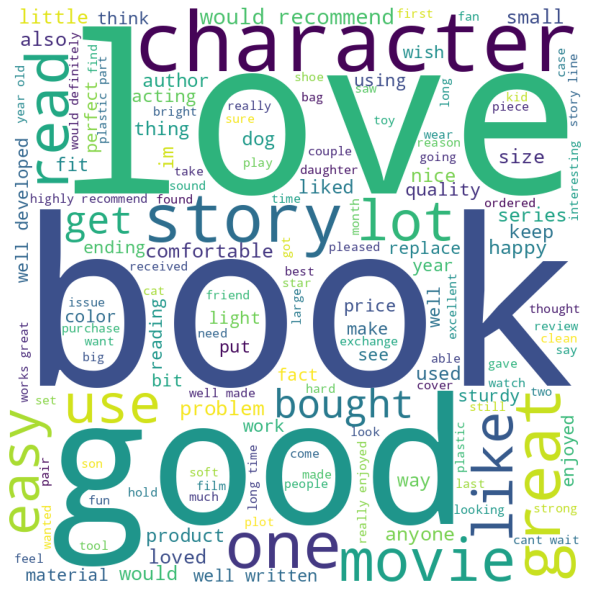

In [10]:
fake_reviews = cg_reviews.text_no_punct
plot_word_cloud(fake_reviews)

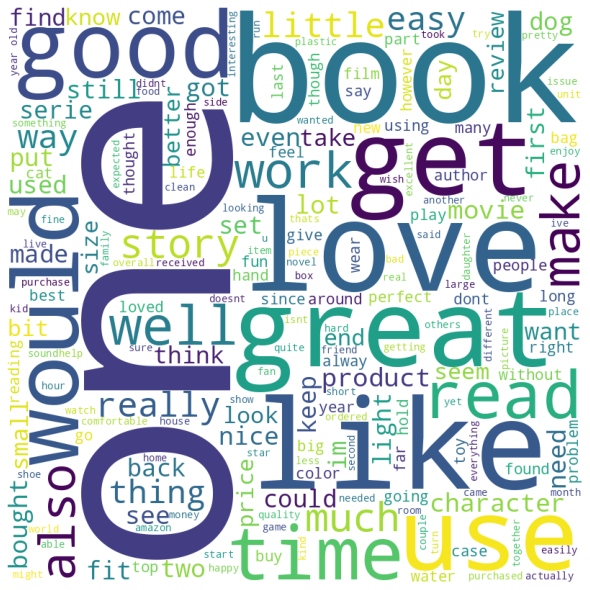

In [11]:
real_reviews = or_reviews.text_no_punct
plot_word_cloud(real_reviews)

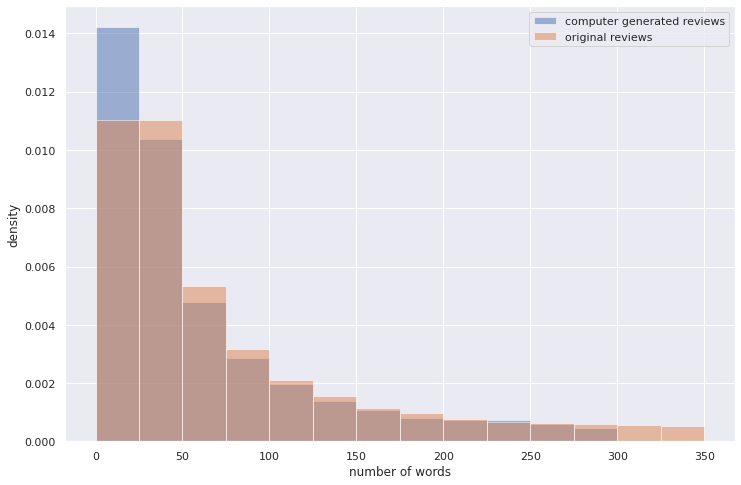

In [12]:
bins = np.arange(0, 375, 25)
plt.figure(figsize=(12, 8))
plt.hist(cg_reviews.num_words,
         label = 'computer generated reviews',
         alpha = 0.5,
         bins = bins,
         density=True)

plt.hist(or_reviews.num_words,
         label = 'original reviews',
         alpha = 0.5,
         bins = bins,
         density=True)

plt.legend()
plt.xlabel('number of words')
plt.ylabel('density')
plt.show()

In [13]:
from scipy.stats import ks_2samp

print(f'Median num words (CG): {cg_reviews.num_words.median()}')
print(f'Median num words (OR): {or_reviews.num_words.median()}')
print()

#testing if original reviews have more words than computer generated reviews
res = ks_2samp(cg_reviews.num_words, or_reviews.num_words, alternative='greater')

print(f'Test Stat: {res[0]}')
print(f'P-value: {res[1]}')

Median num words (CG): 36.0
Median num words (OR): 43.0

Test Stat: 0.09131381084289672
P-value: 5.6671608178102464e-74


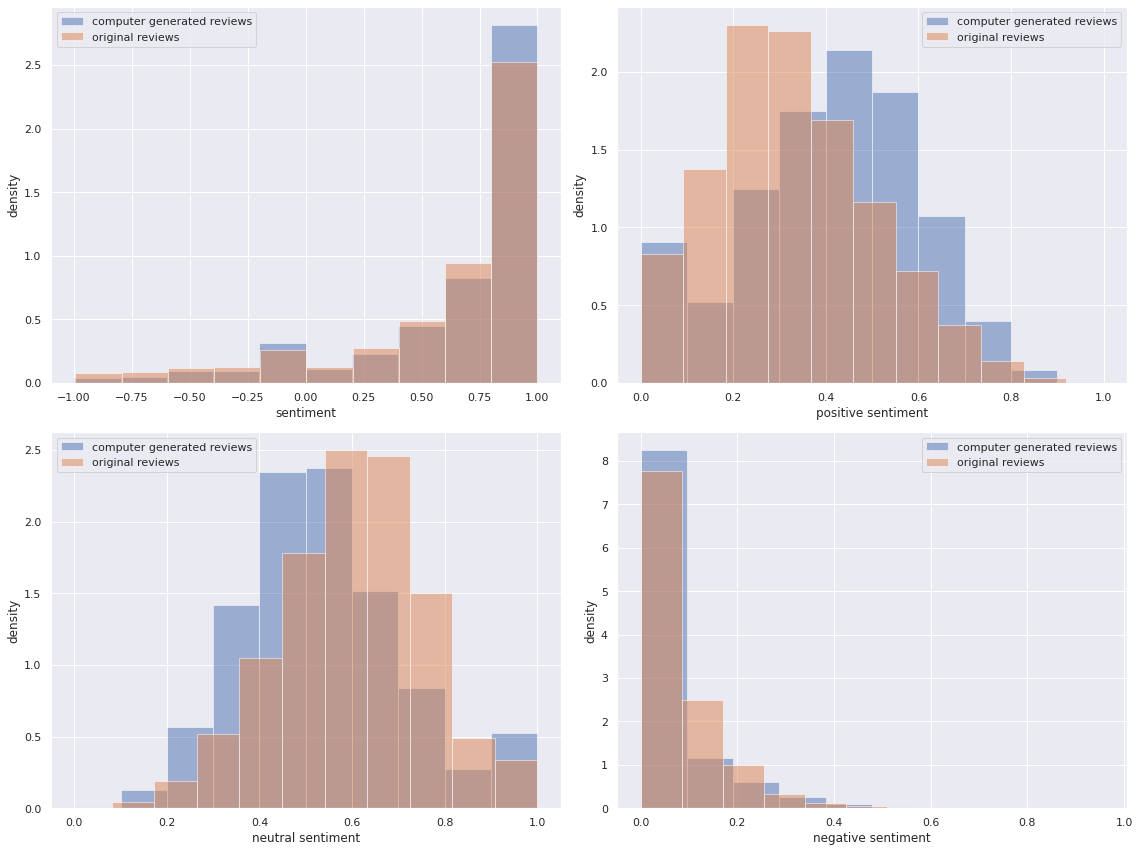

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].hist(cg_reviews.comp_sentiment, alpha=0.5, label='computer generated reviews', density=True)
axes[0, 0].hist(or_reviews.comp_sentiment, alpha=0.5, label='original reviews', density=True)
axes[0, 0].set_xlabel('sentiment')
axes[0, 0].set_ylabel('density')
axes[0, 0].legend()

axes[0, 1].hist(cg_reviews.pos_sentiment, alpha=0.5, label='computer generated reviews', density=True)
axes[0, 1].hist(or_reviews.pos_sentiment, alpha=0.5, label='original reviews', density=True)
axes[0, 1].set_xlabel('positive sentiment')
axes[0, 1].set_ylabel('density')
axes[0, 1].legend()

axes[1, 0].hist(cg_reviews.neu_sentiment, alpha=0.5, label='computer generated reviews', density=True)
axes[1, 0].hist(or_reviews.neu_sentiment, alpha=0.5, label='original reviews', density=True)
axes[1, 0].set_xlabel('neutral sentiment')
axes[1, 0].set_ylabel('density')
axes[1, 0].legend()

axes[1, 1].hist(cg_reviews.neg_sentiment, alpha=0.5, label='computer generated reviews', density=True)
axes[1, 1].hist(or_reviews.neg_sentiment, alpha=0.5, label='original reviews', density=True)
axes[1, 1].set_xlabel('negative sentiment')
axes[1, 1].set_ylabel('density')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [15]:
print(f'Median compound sentiment (CG): {cg_reviews.comp_sentiment.median()}')
print(f'Median compound sentiment (OR): {or_reviews.comp_sentiment.median()}')
print()

#testing if computer-generated reviews have more compound sentiment than original reviews
res = ks_2samp(cg_reviews.comp_sentiment, or_reviews.comp_sentiment, alternative='less')

print(f'Test Stat: {res[0]}')
print(f'P-value: {res[1]}')

Median compound sentiment (CG): 0.8481
Median compound sentiment (OR): 0.802

Test Stat: 0.10551048674317365
P-value: 1.638793668989301e-98


In [16]:
print(f'Median compound sentiment (CG): {cg_reviews.neg_sentiment.median()}')
print(f'Median compound sentiment (OR): {or_reviews.neg_sentiment.median()}')
print()

#testing if computer-generated reviews have less negative sentiment than original reviews
res = ks_2samp(cg_reviews.neg_sentiment, or_reviews.neg_sentiment, alternative='greater')

print(f'Test Stat: {res[0]}')
print(f'P-value: {res[1]}')

Median compound sentiment (CG): 0.0
Median compound sentiment (OR): 0.036

Test Stat: 0.16373169766521567
P-value: 3.6489190646592793e-236


In [17]:
def plot_sentiment_by_rating(emotion):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    sns.boxplot(ax=axes[0], x='rating', y=f'{emotion}_sentiment', data=or_reviews)
    axes[0].set_title('OR Reviews')

    sns.boxplot(ax=axes[1], x='rating', y=f'{emotion}_sentiment', data=cg_reviews)
    axes[1].set_title('CG Reviews')

    plt.tight_layout()
    plt.show() 

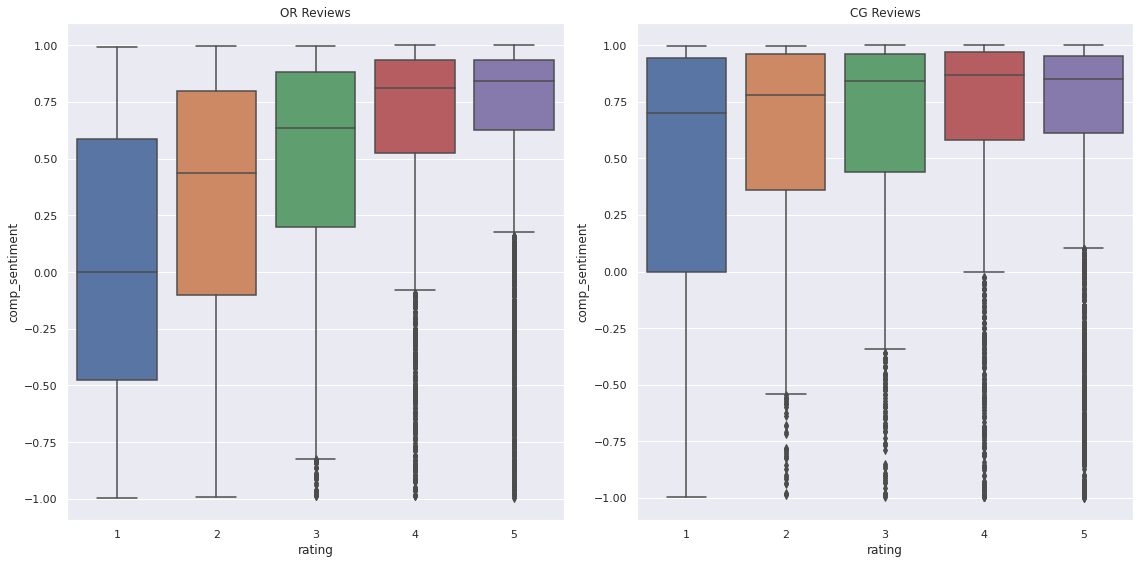

In [18]:
plot_sentiment_by_rating('comp')

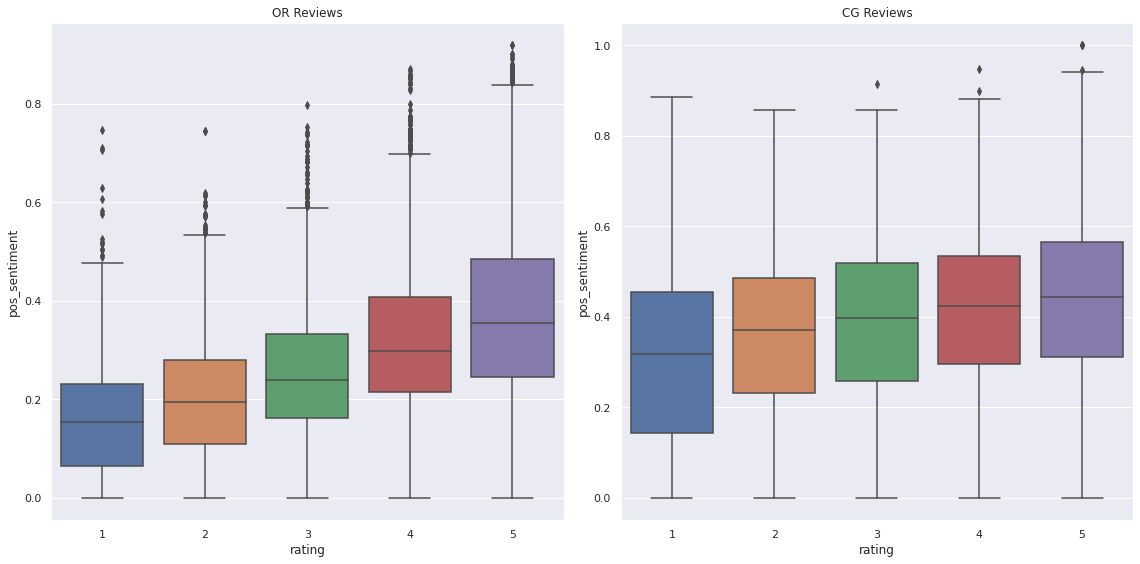

In [19]:
plot_sentiment_by_rating('pos')

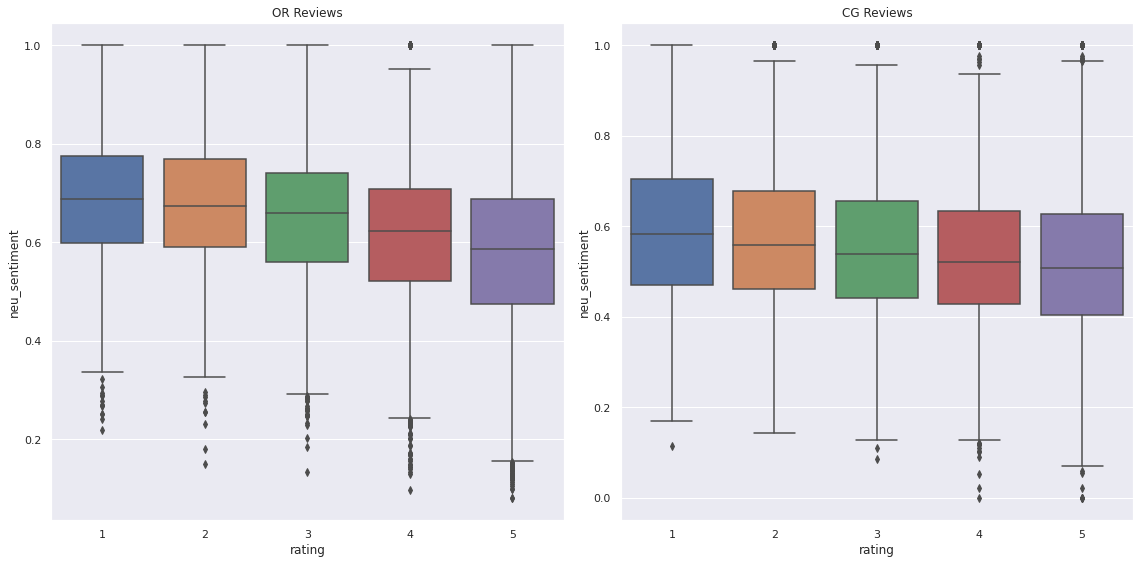

In [20]:
plot_sentiment_by_rating('neu')

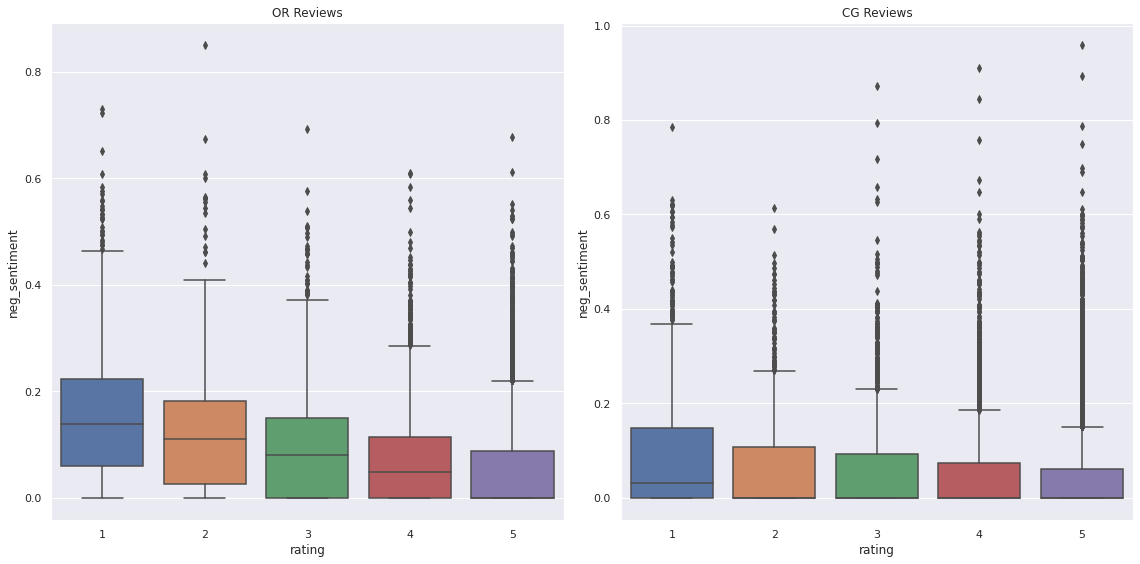

In [21]:
plot_sentiment_by_rating('neg')